In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import swa_gaussian.swag.posteriors as posteriors
import swa_gaussian.swag.utils as utils
import swa_gaussian.swag.losses as losses
import torch
import numpy as np
import torch.optim
import torch.utils.data
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import deque
import typing
import time
import tabulate

import torchvision.models as models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Hyperparameters
LEARNING_RATE = 0.01
EPOCHS = 100
BATCH_SIZE = 128
SWAG_START_EPOCH = 20  # after how many epochs of training to start collecting samples for SWAG
K_SWAG = 30  # maximum number of columns in deviation matrix D
UPDATE_INTERVAL = 1  # how often to update the SWAG model
BMA = 20  # number of samples to use for Bayesian model averaging
EVAL_INTERVAL = 10  # how often to evaluate the model
CIFAR10 = True  # whether to use CIFAR-10 or CIFAR-100

In [4]:
if CIFAR10:
    model_base = models.resnet18(pretrained=False, num_classes=10).to(device)
else:
    model_base = models.resnet18(pretrained=False, num_classes=100).to(device)
    
swag = posteriors.SWAG(model_base, no_cov_mat=True, max_num_models=K_SWAG).to(device)

In [5]:
import torchvision.transforms as transforms
import torchvision


# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# Load CIFAR-10 dataset
if CIFAR10:
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
else:
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

if CIFAR10:
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
else:
    testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
if CIFAR10:
    num_classes = 10
else:
    num_classes = 100
#opt2 = torch.optim.SGD(model_base.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
def schedule(epoch):
    t = (epoch) / (EPOCHS)
    lr_ratio = 0.01
    if t <= 0.5:
        factor = 1.0
    elif t <= 0.9:
        factor = 1.0 - (1.0 - lr_ratio) * (t - 0.5) / 0.4
    else:
        factor = lr_ratio
    return LEARNING_RATE * factor

criterion = losses.cross_entropy
optimizer = torch.optim.SGD(model_base.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)

columns = ["ep", "lr", "tr_loss", "tr_acc", "te_loss", "te_acc", "time", "mem_usage"]

columns = columns[:-2] + ["swa_te_loss", "swa_te_acc"] + columns[-2:]
swag_res = {"loss": None, "accuracy": None}

sgd_ens_preds = None
sgd_targets = None
n_ensembled = 0.0

for epoch in range(EPOCHS):
    time_ep = time.time()
    lr = schedule(epoch)
    utils.adjust_learning_rate(optimizer, lr)
    train_res = utils.train_epoch(trainloader, model_base, criterion, optimizer)
    if epoch == EPOCHS - 1:
        test_res = utils.eval(testloader, model_base, criterion)
    else:
        test_res = {"loss": None, "accuracy": None}
    
    if epoch % EVAL_INTERVAL == 0:
        test_res = utils.eval(testloader, model_base, criterion)
    else:
        test_res = {"loss": None, "accuracy": None}
    
    if epoch >= SWAG_START_EPOCH and epoch % UPDATE_INTERVAL == 0:
        n_ensembled += 1
        swag.collect_model(model_base)
        if epoch % EVAL_INTERVAL == 0:
            swag.sample(0.0)
            utils.bn_update(trainloader, swag)
            swag_res = utils.eval(testloader, swag, criterion)
        else:
            swag_res = {"loss": None, "accuracy": None}

    time_ep = time.time() - time_ep
    memory_usage = torch.cuda.memory_allocated() / (1024.0 ** 3)

    values = [
        epoch + 1,
        lr,
        train_res["loss"],
        train_res["accuracy"],
        test_res["loss"],
        test_res["accuracy"],
        time_ep,
        memory_usage,
    ]

    values = values[:-2] + [swag_res["loss"], swag_res["accuracy"]] + values[-2:]
    table = tabulate.tabulate([values], columns, tablefmt="simple", floatfmt="8.4f")
    if epoch % 40 == 0:
        table = table.split("\n")
        table = "\n".join([table[1]] + table)
    else:
        table = table.split("\n")[2]
    print(table)



----  --------  ---------  --------  ---------  --------  -------------  ------------  --------  -----------
  ep        lr    tr_loss    tr_acc    te_loss    te_acc  swa_te_loss    swa_te_acc        time    mem_usage
----  --------  ---------  --------  ---------  --------  -------------  ------------  --------  -----------
   1    0.0100     1.6650   39.7360     1.4107   49.0600                                 7.1949       0.2275
   2    0.0100     1.3179   52.6540                                                      5.4740       0.2275
   3    0.0100     1.1529   58.9120                                                      5.6418       0.2275
   4    0.0100     1.0361   63.1740                                                      5.5046       0.2275
   5    0.0100     0.9623   65.8520                                                      5.3715       0.2275
   6    0.0100     0.8970   68.3340                                                      5.4982       0.2275
   7    0.0100     

In [7]:
def nll(outputs, labels):
    labels = labels.astype(int)
    idx = (np.arange(labels.size), labels)
    ps = outputs[idx]
    nll = -np.sum(np.log(ps))
    return nll


predictions = np.zeros((len(testset), num_classes))
targets = np.zeros(len(testset))

for i in range(BMA):
    swag.sample(scale=0.5)
    utils.bn_update(trainloader, swag)

    swag.eval()
    k=0

    for input, target in tqdm(testloader):

        torch.manual_seed(i)
        input = input.to(device)
        output = swag(input)
        with torch.no_grad():
            predictions[k : k + input.size()[0]] += (
                torch.nn.functional.softmax(output, dim=1).cpu().numpy()
            )
            targets[k : k + input.size()[0]] = target.numpy()
        k += input.size()[0]
    
    print("Accuracy:", np.mean(np.argmax(predictions, axis=1) == targets))
    #nll is sum over entire dataset
    print("NLL:", nll(predictions / (i + 1), targets))

predictions /= BMA

100%|██████████| 79/79 [00:00<00:00, 104.82it/s]


Accuracy: 0.7991
NLL: 5958.466025967853


100%|██████████| 79/79 [00:00<00:00, 104.19it/s]


Accuracy: 0.7992
NLL: 5956.506228902754


100%|██████████| 79/79 [00:00<00:00, 115.64it/s]


Accuracy: 0.7995
NLL: 5955.177053974156


100%|██████████| 79/79 [00:00<00:00, 105.27it/s]


Accuracy: 0.7993
NLL: 5955.132050660144


100%|██████████| 79/79 [00:00<00:00, 107.67it/s]


Accuracy: 0.7994
NLL: 5955.096752338592


100%|██████████| 79/79 [00:00<00:00, 112.99it/s]


Accuracy: 0.7995
NLL: 5955.229090334362


100%|██████████| 79/79 [00:00<00:00, 100.82it/s]


Accuracy: 0.7995
NLL: 5954.93273634601


100%|██████████| 79/79 [00:00<00:00, 119.77it/s]


Accuracy: 0.7995
NLL: 5954.749584923988


100%|██████████| 79/79 [00:00<00:00, 108.61it/s]


Accuracy: 0.7995
NLL: 5954.688700951938


100%|██████████| 79/79 [00:00<00:00, 106.11it/s]


Accuracy: 0.7995
NLL: 5954.958370360169


100%|██████████| 79/79 [00:00<00:00, 106.81it/s]


Accuracy: 0.7995
NLL: 5954.989677246867


100%|██████████| 79/79 [00:00<00:00, 100.62it/s]


Accuracy: 0.7994
NLL: 5955.132376730075


100%|██████████| 79/79 [00:00<00:00, 105.41it/s]


Accuracy: 0.7994
NLL: 5955.185980333023


100%|██████████| 79/79 [00:00<00:00, 111.05it/s]


Accuracy: 0.7994
NLL: 5955.160993292906


100%|██████████| 79/79 [00:00<00:00, 114.01it/s]


Accuracy: 0.7995
NLL: 5955.119716763492


100%|██████████| 79/79 [00:00<00:00, 104.73it/s]


Accuracy: 0.7996
NLL: 5955.252094758159


100%|██████████| 79/79 [00:00<00:00, 117.83it/s]


Accuracy: 0.7994
NLL: 5955.252564916397


100%|██████████| 79/79 [00:00<00:00, 110.40it/s]


Accuracy: 0.7994
NLL: 5955.171031454161


100%|██████████| 79/79 [00:00<00:00, 114.80it/s]


Accuracy: 0.7994
NLL: 5955.187713852239


100%|██████████| 79/79 [00:00<00:00, 102.80it/s]

Accuracy: 0.7994
NLL: 5954.965732417482


In [8]:
def calc_calibration_curve(predicted_probabilities: np.ndarray, labels: np.ndarray, num_bins: int):
    """
    Calculates a calibration curve to be used in reliability diagrams and returns an ECE
    """

    num_samples, num_classes = predicted_probabilities.shape
    predicted_classes = np.argmax(predicted_probabilities, axis=1)
    confidences = predicted_probabilities[range(num_samples), predicted_classes]
    bins = np.linspace(start=0, stop=1, num=num_bins + 1)

    bin_lowers = bins[:-1]
    bin_uppers = bins[1:]
    accuracies = predicted_classes == labels

    calib_confidence = np.zeros(num_bins, dtype=np.float32)
    calib_accuracy = np.zeros(num_bins, dtype=np.float32)
    ratios = np.zeros(num_bins, dtype=np.float32)
    ece = 0.0

    for bin_i, (bin_lower, bin_upper) in enumerate(zip(bin_lowers, bin_uppers)):
        in_bin = (confidences > bin_lower) * (confidences < bin_upper)
        prop_in_bin = in_bin.mean()
        if prop_in_bin > 0:
            accuracy_in_bin = accuracies[in_bin].mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            calib_confidence[bin_i] = avg_confidence_in_bin
            calib_accuracy[bin_i] = accuracy_in_bin
            ratios[bin_i] = prop_in_bin

    return {
        "calib_confidence": calib_confidence,
        "calib_accuracy": calib_accuracy,
        "p": ratios,
        "bins": bins,
        "ece": ece,
    }

def draw_reliability_diagram(out, title="Reliability Diagram", xlabel="Confidence", ylabel="Accuracy"):
    """Draws a reliability diagram into a subplot."""
    fig, ax = plt.subplots()
    accuracies = out["calib_accuracy"]
    confidences = out["calib_confidence"]
    counts = out["p"]
    bins = out["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size / 2.0

    widths = bin_size
    alphas = 0.3

    colors = np.zeros((len(counts), 4))
    colors[:, 0] = 240 / 255.0
    colors[:, 1] = 60 / 255.0
    colors[:, 2] = 60 / 255.0
    colors[:, 3] = alphas

    gap_plt = ax.bar(
        positions,
        np.abs(accuracies - confidences),
        bottom=np.minimum(accuracies, confidences),
        width=widths,
        edgecolor=colors,
        color=colors,
        linewidth=1,
        label="Gap",
    )

    acc_plt = ax.bar(
        positions,
        0,
        bottom=accuracies,
        width=widths,
        edgecolor="black",
        color="black",
        alpha=1.0,
        linewidth=3,
        label="Accuracy",
    )

    ax.set_aspect("equal")
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray")

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(handles=[gap_plt, acc_plt])
    fig.tight_layout()
    return fig


Validation ECE: 0.038581730411201706


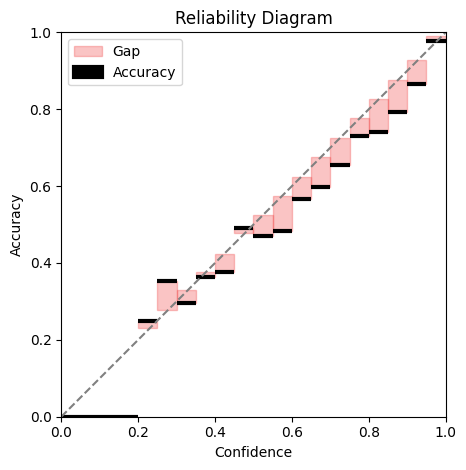

In [9]:
calibration_data_swag = calc_calibration_curve(predictions, targets, num_bins=20)

print("\nValidation ECE:", calibration_data_swag["ece"])

fig = draw_reliability_diagram(calibration_data_swag)

plt.show()

In [10]:
pred_labels = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Accuracy:", accuracy_score(targets, pred_labels))
print("F1 Score:", f1_score(targets, pred_labels, average="weighted"))
print("Precision:", precision_score(targets, pred_labels, average="weighted"))
print("Recall:", recall_score(targets, pred_labels, average="weighted"))

Accuracy: 0.7994
F1 Score: 0.7987160952443905
Precision: 0.7993738356712206
Recall: 0.7994
